We shall start by importing the essential libraries.

In [1]:
### IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, recall_score, roc_curve, roc_auc_score
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

Next, we clean the data and bring it to a form which will make the model building process easy. This phase is done exactly the same way as in 00 - Stroke EDA.

In [2]:
### DATA PREPARATION
stroke = pd.read_csv('healthcare-dataset-stroke-data.csv', na_values = [np.NaN, ' '])

df = pd.DataFrame(stroke)
df = df.drop(['id'], axis = 1)

num_vars = df.select_dtypes(include = ['int64', 'float64'])
cat_vars = df.select_dtypes(include = 'object')
feature_names = collections.defaultdict(str)
for name in num_vars.columns:
    feature_names[name]
for name in cat_vars.columns:
    feature_names[name]

mean_imputer = SimpleImputer(strategy = 'mean')
imputed_vars = mean_imputer.fit_transform(num_vars)
df_imputed = pd.DataFrame(np.hstack([imputed_vars, cat_vars]), columns = feature_names)

df_imputed['age'] = df_imputed['age'].astype('float64')
df_imputed['hypertension'] = df_imputed['hypertension'].astype('int64')
df_imputed['heart_disease'] = df_imputed['heart_disease'].astype('int64')
df_imputed['avg_glucose_level'] = df_imputed['avg_glucose_level'].astype('float64')
df_imputed['bmi'] = df_imputed['bmi'].astype('float64')
df_imputed['stroke'] = df_imputed['stroke'].astype('int64')

capping = num_vars.select_dtypes(include = 'float64')
for col in df_imputed.columns:
    if col in capping.columns:
        percentile = df_imputed[col].quantile([0.05, 0.95]).values
        df_imputed[col] = df_imputed[col].clip(lower = percentile[0], upper = percentile[1])

df_final = pd.get_dummies(df_imputed, columns = ['gender', 'ever_married', 'work_type', 'Residence_type',
                                              'smoking_status'], drop_first = True)

Now we separate the independent and dependent features; we label them X and y respectively. Then, we separate data for training and testing sets in the ratio of 8:2, making sure that the imbalance in the levels of the target variable, y, is maintained in both the sets. In other words, both the training and testing sets have the same proportion of people who did not suffer from stroke and those who did.

In [3]:
### SEPARATING TRAIN AND TEST SETS
X = df_final.drop(['stroke'], axis = 1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 99)

Since Support Vector Machine makes use of distances, it would be wise to scale the continuous variables. Doing so would eliminate the risk of variables with large values having a larger say in the model.

In [4]:
### SCALING CONTINUOUS VARIABLES
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

We now go on to make a simple SVM model, which will serve as our baseline. Remember that the data was highly unbalanced in that the number of people who did not suffer from stroke was far more than those who did. To overcome this problem, we simply set the weights of the levels of y as balanced. What this does is that it assigns weights to the two levels of y, the weight of each level being inversely proportional to its frequency.


So, we build the model with class weights as balanced and set probability as True which will help us to make ROC curves later on. We fit the training data and plot the confusion matrix.

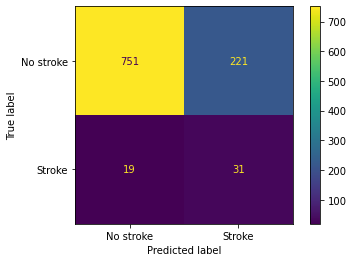

In [5]:
### CREATING A BASELINE MODEL
clf_svm = SVC(random_state = 99, class_weight = 'balanced', probability = True)
clf_svm.fit(X_train_scaled, y_train)
plot_confusion_matrix(clf_svm, X_test_scaled, y_test, display_labels = ['No stroke', 'Stroke'])

Before we proceed, let's take a look at the distribution of the levels of y in our dataset.

In [6]:
df['stroke'].value_counts(normalize = True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

Here, we see that around 95% of the people in our dataset have not suffered from stroke as opposed to just about 5% who actually have. This means that even if our model predicts every person as not having a stroke, the model will still be 95% accurate at the very least. So, in this case, accuracy is a deceptive metric. 


What we should rather be concerned with is the number of people who actually had stroke but were not identified by the model as having stroke i.e. the False Negatives. Lower the FN value, lower is the risk of overlooking a possible case of stroke and thus better is the model because the main objective of the model here should be to possibly save lives by correctly identifying a stroke case as early as possible. To reduce the FN value, we need to ensure that the recall of stroke cases is high since recall and FN are inversely proportional.


So, we shall calculate the accuracy and recall values for the predictions made by the model.

In [7]:
### CALCULATING ESSENTIAL METRICS
y_pred_svm = clf_svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred_svm, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_svm))
print('Recall score: %f' % recall_score(y_test, y_pred_svm))

              precision    recall  f1-score   support

   No stroke       0.98      0.77      0.86       972
      Stroke       0.12      0.62      0.21        50

    accuracy                           0.77      1022
   macro avg       0.55      0.70      0.53      1022
weighted avg       0.93      0.77      0.83      1022

Accuracy: 0.765166
Recall score: 0.620000


If we look at the confusion matrix, we see that out of the 50 cases that had actually suffered from stroke, 31 were correctly predicted as having a stroke by our model while 19 were overlooked. This gives us a recall score of 62% while the accuracy is about 76%.

Next, we plot the ROC curve and calculate the AUC score.

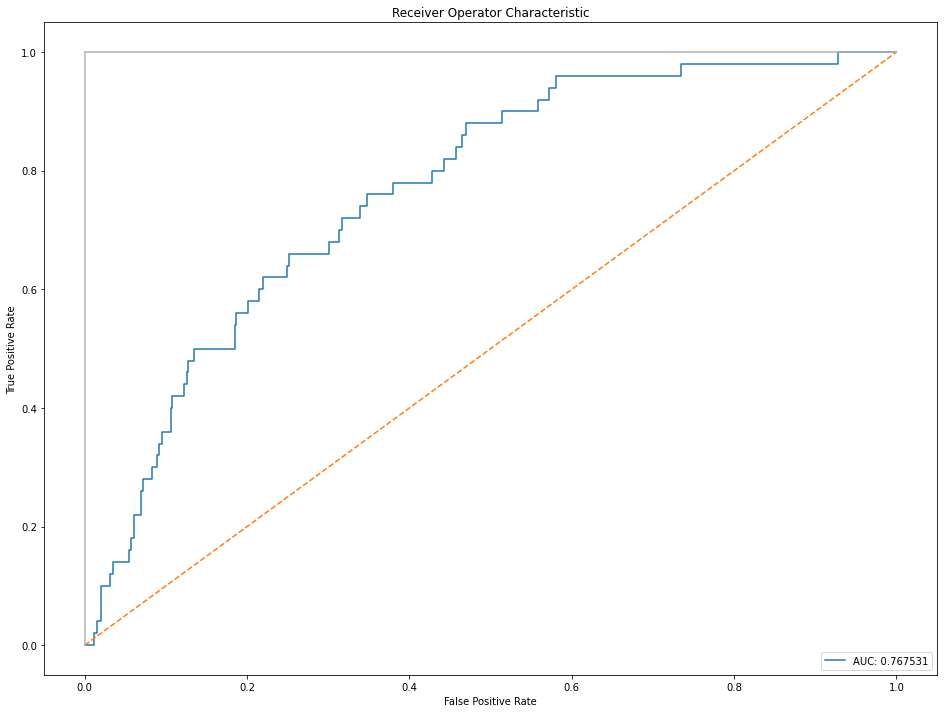

In [8]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_svm = clf_svm.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_svm)
roc_auc = roc_auc_score(y_test, y_prob_svm)
plt.figure(figsize = (16, 12))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We get an AUC score of about 0.7675. 


Now, we will try to improve the baseline model by tuning it's hyperparameters. For this, we shall use a random search across the possible hyperparameter values. We create a pipeline which first separates and scales some portion of the training data, then uses it to create a model which will test on the remaining data; we will do this 3 times over via 3 fold cross-validation.


Here, the hyperparameters being tuned are as follows:
1. C: the regularization term which signifies how hard or soft the decision boundary is going to be since it is the cost for the misclassified points
2. kernel: the type of hyperplane to be used to separate data
3. gamma: kernel coefficient for non-linear hyperplanes
4. degree: the degree of the polynomial kernel function

As we are trying to decrease the FN value, we will use roc_auc as our scoring parameter.

In [9]:
### TUNING HYPERPARAMETER VALUES USING RANDOMIZED SEARCH
svc = SVC(random_state = 99, class_weight = 'balanced')
scaler = StandardScaler()
pipe = Pipeline([('scaler', scaler), ('svc', svc)])
search_space = [{'svc__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 7, 10, 20],
                'svc__gamma':[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                'svc__kernel': ['rbf']},
               {'svc__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 7, 10, 20],
                'svc__gamma':[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                'svc__degree': [1, 2, 3, 4],
                'svc__kernel': ['poly']}]
grid_fit = RandomizedSearchCV(pipe, 
                              search_space, 
                              n_iter = 30, 
                              scoring = 'roc_auc', 
                              cv = 3, 
                              verbose = 2, 
                              random_state = 99,
                              n_jobs = -1)
grid_fit.fit(X_train, y_train)
print(grid_fit.best_params_)
print('Best C value: %f' % grid_fit.best_estimator_.get_params()['svc__C'])
print('Best gamma value: %f' % grid_fit.best_estimator_.get_params()['svc__gamma'])
print('Best kernel value: %s' % grid_fit.best_estimator_.get_params()['svc__kernel'])

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   38.3s finished


{'svc__kernel': 'poly', 'svc__gamma': 0.01, 'svc__degree': 1, 'svc__C': 1}
Best C value: 1.000000
Best gamma value: 0.010000
Best kernel value: poly


Now, with these tuned parameter values, we shall create our final Support Vector Machine model.

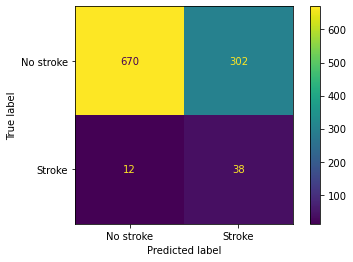

In [10]:
### CREATING THE FINAL MODEL
clf_svm = SVC(random_state = 99,
              class_weight = 'balanced', 
              kernel = 'poly',
              gamma = 0.01,
              degree = 1,
              C = 1,
              probability = True)
clf_svm.fit(X_train_scaled, y_train)
plot_confusion_matrix(clf_svm, X_test_scaled, y_test, display_labels = ['No stroke', 'Stroke'])

Of the 50 stroke cases, the final model predicts only 38 correctly while it fails to do the same for the remaining 12. This means that the model is better than our baseline. 

In [11]:
### CALCULATING ESSENTIAL METRICS
y_pred_svm = clf_svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred_svm, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_svm))
print('Recall score: %f' % recall_score(y_test, y_pred_svm))

              precision    recall  f1-score   support

   No stroke       0.98      0.69      0.81       972
      Stroke       0.11      0.76      0.19        50

    accuracy                           0.69      1022
   macro avg       0.55      0.72      0.50      1022
weighted avg       0.94      0.69      0.78      1022

Accuracy: 0.692759
Recall score: 0.760000


The recall score has gone up to 76% which makes this model better than the baseline. Also, keep in mind that the accuracy has gone down to about 69%, pointing to the already established fact that accuracy is a deceptive metric in this case.

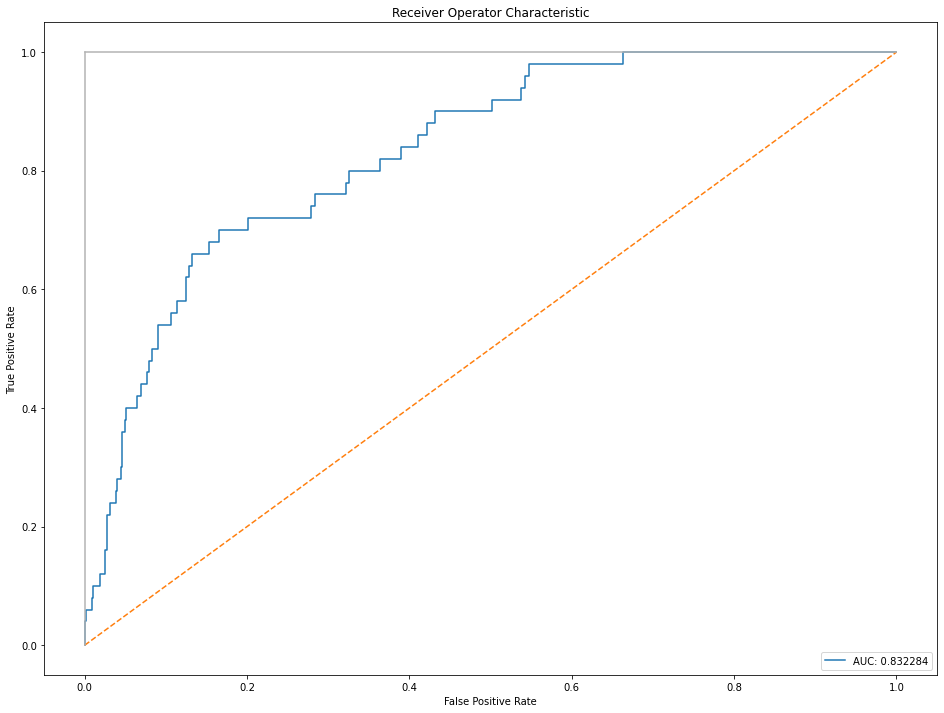

In [12]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_svm = clf_svm.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_svm)
roc_auc = roc_auc_score(y_test, y_prob_svm)
plt.figure(figsize = (16, 12))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The AUC score for this model is 0.8323, which is more than it's predecessor. This further proves that the final model is the still better than the baseline.


Now, let us try and plot the decision boundary. Since the number of features is high, it will be hard for us to visualize the boundary since the dimension of the figure is equal to the number of features. So first, we shall reduce the dimensionality of the dataset by using PCA to bring it down to two dimensions, then we shall use a random search across the possible hyperparameter values to get the corresponding SVM model. We create a pipeline which first separates and scales some portion of the training data, then uses PCA to reduce it's dimensionality by taking only the first two Principal Components, and finally uses them to create a model which will test on the remaining data; we will do this 3 times over via 3 fold cross-validation. 

In [13]:
### PERFORMING PCA AND TUNING HYPERPARAMETERS VIA RANDOMIZED SEARCH
svc = SVC(random_state = 99, class_weight = 'balanced')
scaler = StandardScaler()
pca = PCA(n_components = 2)
preprocess = FeatureUnion([('std', scaler), ('pca', pca)])
pipe = Pipeline([('preprocess', preprocess), ('svc', svc)])
search_space = [{'svc__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 7, 10, 20],
                'svc__gamma':[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                'svc__kernel': ['rbf']},
               {'svc__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 7, 10, 20],
                'svc__gamma':[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                'svc__degree': [1, 2, 3, 4],
                'svc__kernel': ['poly']}]
grid_fit = RandomizedSearchCV(pipe, 
                              search_space, 
                              n_iter = 5, 
                              scoring = 'roc_auc', 
                              cv = 3, 
                              verbose = 2, 
                              random_state = 99,
                              n_jobs = -1)
grid_fit.fit(X_train, y_train)
print(grid_fit.best_params_)
print('Best C value: %f' % grid_fit.best_estimator_.get_params()['svc__C'])
print('Best gamma value: %f' % grid_fit.best_estimator_.get_params()['svc__gamma'])
print('Best kernel value: %s' % grid_fit.best_estimator_.get_params()['svc__kernel'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 63.6min finished


{'svc__kernel': 'rbf', 'svc__gamma': 0.01, 'svc__C': 0.1}
Best C value: 0.100000
Best gamma value: 0.010000
Best kernel value: rbf


With these hyperparameter values, we shall create the SVM model for the first two Principal Components and plot their decision boundary.

Text(0.5, 1.0, 'SVM Decision Region Boundary')

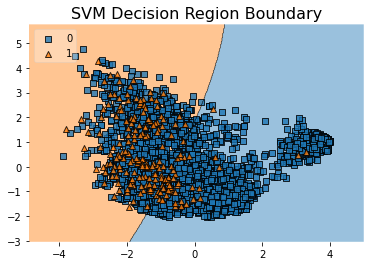

In [13]:
### PLOTTING DECISION BOUNDARIES FOR THE PCA SVM MODEL
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train_scaled)
clf_svm = SVC(random_state = 99,
              class_weight = 'balanced', 
              kernel = 'rbf',
              gamma = 0.01,
              C = 0.1,
              probability = True)
clf_svm.fit(X_train_pca, y_train)
plot_decision_regions(X = X_train_pca, y = y_train.values, clf = clf_svm, legend = 2)
plt.title('SVM Decision Region Boundary', size = 16)

We can clearly see the boundary which separates most of the stroke cases.